<a href="https://colab.research.google.com/github/dheemen0301/landslide_prediction/blob/main/ICEM_Team2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Landslide Prediction using ML Models**

## Import libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

from sklearn import datasets
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
import warnings

warnings.filterwarnings('ignore')

## Import dataset

In [ ]:
df= pd.read_csv('/content/dataset.csv')
df

Gradient  Soil Density  ...       FOS  Labels
0    46.68023      1633.958  ... -2.919169       0
1    48.04759      1635.787  ... -2.897806       0
2    47.22329      1632.190  ... -2.405232       0
3    49.46063      1638.188  ... -2.303489       0
4    46.29549      1635.286  ... -2.174276       0
..        ...           ...  ...       ...     ...
489  48.25859      1635.774  ...  1.562052       1
490  47.19682      1636.783  ...  1.575393       1
491  48.26496      1635.336  ...  1.632755       1
492  48.22114      1635.283  ...  1.676139       1
493  45.74900      1634.843  ...  1.747634       1

[494 rows x 10 columns]

In [ ]:
# view dimensions of dataset

df.shape

(494, 10)

There are 10 variables in the dataset. 8 are feature vectors. FOS(Factor of Safety) was calculated using the feature values. The discrete variable is `Labels` variable. It is also the target variable.The labels used are 0 (negative) and 1 (positive).

In [ ]:
col_names = df.columns
col_names

Index(['Gradient', 'Soil Density', 'Angle of friction', 'Rainfall', 'Cohesion',
       'Soil water density', 'Soil depth', 'Water table height', 'FOS',
       'Labels'],
      dtype='object')

In [ ]:
# check distribution of Labels column
df['Labels'].value_counts()

0    316
1    178
Name: Labels, dtype: int64

In [ ]:
# view the percentage distribution of Labels column
df['Labels'].value_counts()/np.float(len(df))

0    0.639676
1    0.360324
Name: Labels, dtype: float64

The percentage of observations of the class label `0` and `1` is 63.97% and 36.03%. So, the class is imbalanced.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gradient            494 non-null    float64
 1   Soil Density        494 non-null    float64
 2   Angle of friction   494 non-null    float64
 3   Rainfall            494 non-null    float64
 4   Cohesion            494 non-null    float64
 5   Soil water density  494 non-null    float64
 6   Soil depth          494 non-null    float64
 7   Water table height  494 non-null    float64
 8   FOS                 494 non-null    float64
 9   Labels              494 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 38.7 KB


There are no missing values in the dataset as the Non-Null count is equal to the total no of examples.

In [ ]:
round(df.describe(),2)

Gradient  Soil Density  ...     FOS  Labels
count    494.00        494.00  ...  494.00  494.00
mean      47.47       1635.48  ...    0.19    0.36
std        1.46          1.58  ...    1.03    0.48
min       42.75       1629.35  ...   -2.92    0.00
25%       46.52       1634.43  ...   -0.19    0.00
50%       47.39       1635.55  ...    0.09    0.00
75%       48.43       1636.54  ...    1.26    1.00
max       51.62       1640.22  ...    1.75    1.00

[8 rows x 10 columns]

### Outliers in numerical variables

In [ ]:
# draw boxplots to visualize outliers

plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = df.boxplot(column='Gradient')
fig.set_title('')
fig.set_ylabel('Gradient')


plt.subplot(4, 2, 2)
fig = df.boxplot(column='Soil Density')
fig.set_title('')
fig.set_ylabel('Soil Density')


plt.subplot(4, 2, 3)
fig = df.boxplot(column='Angle of friction')
fig.set_title('')
fig.set_ylabel('Angle of friction')


plt.subplot(4, 2, 4)
fig = df.boxplot(column='Rainfall')
fig.set_title('')
fig.set_ylabel('Rainfall')


plt.subplot(4, 2, 5)
fig = df.boxplot(column='Cohesion')
fig.set_title('')
fig.set_ylabel('Cohesion')


plt.subplot(4, 2, 6)
fig = df.boxplot(column='Soil water density')
fig.set_title('')
fig.set_ylabel('Soil water density')


plt.subplot(4, 2, 7)
fig = df.boxplot(column='Soil depth')
fig.set_title('')
fig.set_ylabel('Soil depth')


plt.subplot(4, 2, 8)
fig = df.boxplot(column='Water table height')
fig.set_title('')
fig.set_ylabel('Water table height')

Text(0, 0.5, 'Water table height')

The above boxplots confirm that there are lot of outliers in these variables.

### Handle outliers with SVMs


There are 2 variants of SVMs. They are `hard-margin variant of SVM` and `soft-margin variant of SVM`.


The `hard-margin variant of SVM` does not deal with outliers. In this case, we want to find the hyperplane with maximum margin such that every training point is correctly classified with margin at least 1. This technique does not handle outliers well.


Another version of SVM is called `soft-margin variant of SVM`. In this case, we can have a few points incorrectly classified or 
classified with a margin less than 1. But for every such point, we have to pay a penalty in the form of `C` parameter, which controls the outliers. `Low C` implies we are allowing more outliers and `high C` implies less outliers.


The message is that since the dataset contains outliers, so the value of C should be high while training the model.

### Check the distribution of variables


In [ ]:
# plot histogram to check distribution


plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = df['Gradient'].hist(bins=20)
fig.set_xlabel('Gradient')



plt.subplot(4, 2, 2)
fig = df['Soil Density'].hist(bins=20)
fig.set_xlabel('Soil Density')



plt.subplot(4, 2, 3)
fig = df['Angle of friction'].hist(bins=20)
fig.set_xlabel('Angle of friction')




plt.subplot(4, 2, 4)
fig = df['Rainfall'].hist(bins=20)
fig.set_xlabel('Rainfall')




plt.subplot(4, 2, 5)
fig = df['Cohesion'].hist(bins=20)
fig.set_xlabel('Cohesion')




plt.subplot(4, 2, 6)
fig = df['Soil water density'].hist(bins=20)
fig.set_xlabel('Soil water density')




plt.subplot(4, 2, 7)
fig = df['Soil depth'].hist(bins=20)
fig.set_xlabel('Soil depth')



plt.subplot(4, 2, 8)
fig = df['Water table height'].hist(bins=20)
fig.set_xlabel('Water table height')



Text(0.5, 0, 'Water table height')

All the 8 features are skewed. 

## 9. Declare feature vector and target variable

In [ ]:
X = df.drop(columns = ['FOS','Labels'], axis=1)
y = df['Labels']

## 10. Split data into separate training and test set

In [ ]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,stratify=y, random_state = 80)
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify=y, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((395, 8), (99, 8))

## 11. Feature Scaling

In [ ]:
cols = X_train.columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)


In [ ]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [ ]:
X_test = pd.DataFrame(X_test, columns=[cols])

# LOGISTIC REGRESSION

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, y_train) 
print('Accuracy on training data : ', training_data_accuracy)
X_test_prediction = model.predict(X_test)
pred_log=X_test_prediction
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
acc_log=test_data_accuracy 
print('Accuracy on test data : ', test_data_accuracy)

Accuracy on training data :  0.979746835443038
Accuracy on test data :  0.9696969696969697


# RANDOM FOREST

In [ ]:
forest = RandomForestClassifier(criterion='gini', n_estimators=4, random_state=42, n_jobs=2)
forest.fit(X_train, y_train)
X_train_prediction = forest.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, y_train) 
print('Accuracy on training data : ', training_data_accuracy)
X_test_prediction = forest.predict(X_test)
pred_rand=X_test_prediction
test_data_accuracy = accuracy_score(y_test,X_test_prediction) 
acc_rand=test_data_accuracy
print('Accuracy on test data : ', test_data_accuracy)
#y_pred = forest.predict(X_test)
#print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy on training data :  0.9569620253164557
Accuracy on test data :  0.8686868686868687


# ADABOOST 

In [ ]:
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000]
	for n in n_trees:
		models[str(n)] = AdaBoostClassifier(n_estimators=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.4f' % (name, np.mean(scores)))

>10 0.8914
>50 0.9265
>100 0.9345
>500 0.9359
>1000 0.9359


In [ ]:
#Since accuracy of 1000 trees is highest, predicting labels for the model with 1000 trees
model = AdaBoostClassifier(n_estimators=1000)
# fit the model on the whole dataset
model.fit(X_train, y_train)
# Prediction
y_pred = model.predict(X_test)
pred_adab=y_pred
acc_adab=0.9359

## Run SVM with rbf kernel and C=1.0, 10.0, 100.0, 1000.0 and gamma=`auto` among other parameters.

In [ ]:
# import SVC classifier
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


#C=1.0
svc=SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#C=10.0
svc=SVC(C=10.0) 
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Model accuracy score with rbf kernel and C=10.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#C=100.0
svc=SVC(C=100.0) 
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#C=1000
svc=SVC(C=1000.0) 
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.9394
Model accuracy score with rbf kernel and C=10.0 : 0.8889
Model accuracy score with rbf kernel and C=100.0 : 0.8889
Model accuracy score with rbf kernel and C=1000.0 : 0.8889


## 13. Run SVM with linear kernel and C=1.0, 10.0, 100.0, 1000.0


In [ ]:
#C=1.0
linear_svc=SVC(kernel='linear', C=1.0) 
linear_svc.fit(X_train,y_train)
y_pred_test=linear_svc.predict(X_test)
pred_svm=y_pred_test
acc_svm=(accuracy_score(y_test, y_pred_test))
print(acc_svm)
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))


#C=10.0
linear_svc10=SVC(kernel='linear', C=10.0) 
linear_svc10.fit(X_train, y_train)
y_pred=linear_svc10.predict(X_test)
print('Model accuracy score with linear kernel and C=10.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


#c=100.0
linear_svc100=SVC(kernel='linear', C=100.0) 
linear_svc100.fit(X_train, y_train)
y_pred=linear_svc100.predict(X_test)
print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


#C=1000.0
linear_svc1000=SVC(kernel='linear', C=1000.0) 
linear_svc1000.fit(X_train, y_train)
y_pred=linear_svc1000.predict(X_test)
print('Model accuracy score with linear kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

0.9696969696969697
Model accuracy score with linear kernel and C=1.0 : 0.9697
Model accuracy score with linear kernel and C=10.0 : 0.9495
Model accuracy score with linear kernel and C=100.0 : 0.9394
Model accuracy score with linear kernel and C=1000.0 : 0.9495


### Comparing the train-set and test-set accuracy

In [ ]:
y_pred_train = linear_svc.predict(X_train)

y_pred_train

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9797


The training set and test-set accuracy are very much comparable.

### Check for overfitting and underfitting

In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(linear_svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(linear_svc.score(X_test, y_test)))

Training set score: 0.9797
Test set score: 0.9697


### Running SVM with polynomial kernel and C=1.0 and 100.0

In [ ]:
#C=1.0
poly_svc=SVC(kernel='poly', C=1.0) 
poly_svc.fit(X_train,y_train)
y_pred=poly_svc.predict(X_test)
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


#C=100.0
poly_svc=SVC(kernel='poly', C=100.0) 
poly_svc.fit(X_train,y_train)
y_pred=poly_svc.predict(X_test)
print('Model accuracy score with polynomial kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with polynomial kernel and C=1.0 : 0.8990
Model accuracy score with polynomial kernel and C=100.0 : 0.8283


## Confusion matrix


A confusion matrix is a tool for summarizing the performance of a classification algorithm.
Four types of outcomes are possible while evaluating a classification model performance. These four outcomes are:-

**True Positives (TP)**

**True Negatives (TN)**

**False Positives (FP)**

**False Negatives (FN)**

In [ ]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[61  2]
 [ 1 35]]

True Positives(TP) =  61

True Negatives(TN) =  35

False Positives(FP) =  2

False Negatives(FN) =  1


The confusion matrix shows `3289 + 230 = 3519 correct predictions` and `17 + 44 = 61 incorrect predictions`.


In this case, we have


- `True Positives` (Actual Positive:1 and Predict Positive:1) - 3289


- `True Negatives` (Actual Negative:0 and Predict Negative:0) - 230


- `False Positives` (Actual Negative:0 but Predict Positive:1) - 17 `(Type I error)`


- `False Negatives` (Actual Positive:1 but Predict Negative:0) - 44 `(Type II error)`

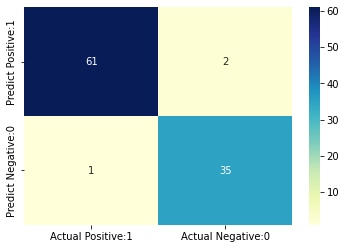

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### Classification Report


**Classification report** is another way to evaluate the classification model performance. It displays the  **precision**, **recall**, **f1** and **support** scores for the model. I have described these terms in later.

We can print a classification report as follows:-

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98        63
           1       0.95      0.97      0.96        36

    accuracy                           0.97        99
   macro avg       0.96      0.97      0.97        99
weighted avg       0.97      0.97      0.97        99



### Classification accuracy

In [ ]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [ ]:
# print classification accuracy

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))


Classification accuracy : 0.9697


### Classification error

In [ ]:
# print classification error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))


Classification error : 0.0303


### Precision

In [ ]:
# print precision score

precision = TP / float(TP + FP)


print('Precision : {0:0.4f}'.format(precision))


Precision : 0.9683


### Recall

In [ ]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.9839


### True Positive Rate

In [ ]:
true_positive_rate = TP / float(TP + FN)


print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

True Positive Rate : 0.9839


### False Positive Rate

In [ ]:
false_positive_rate = FP / float(FP + TN)


print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

False Positive Rate : 0.0541


### Specificity

In [ ]:
specificity = TN / (TN + FP)

print('Specificity : {0:0.4f}'.format(specificity))

Specificity : 0.9459


### ROC Curve


Another tool to measure the classification model performance visually is **ROC Curve**.
The **ROC Curve** plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold levels.


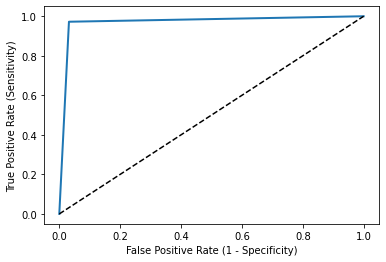

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(y_test, y_pred_test)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.9702



The higher the value of ROC AUC, the better the classifier. ROC AUC of our model approaches towards 1. So, we can conclude that our classifier does a good job.

k-fold cross-validation is a very useful technique to evaluate model performance. But, it fails here because we have a imbalanced dataset.

### Stratified k-Fold Cross Validation with shuffle split with  linear kernel

In [ ]:
from sklearn.model_selection import KFold


kfold=KFold(n_splits=5, shuffle=True, random_state=0)


linear_svc=SVC(kernel='linear')


linear_scores = cross_val_score(linear_svc, X, y, cv=kfold)


In [ ]:
# print cross-validation scores with linear kernel

print('Stratified cross-validation scores with linear kernel:\n\n{}'.format(linear_scores))

Stratified cross-validation scores with linear kernel:

[0.82828283 0.90909091 0.85858586 0.92929293 0.89795918]


In [ ]:
# print average cross-validation score with linear kernel

print('Average stratified cross-validation score with linear kernel:{:.4f}'.format(linear_scores.mean()))

Average stratified cross-validation score with linear kernel:0.8846


### Stratified k-Fold Cross Validation with shuffle split with rbf kernel

In [ ]:
rbf_svc=SVC(kernel='rbf')


rbf_scores = cross_val_score(rbf_svc, X, y, cv=kfold)

In [ ]:
# print cross-validation scores with rbf kernel

print('Stratified Cross-validation scores with rbf kernel:\n\n{}'.format(rbf_scores))

Stratified Cross-validation scores with rbf kernel:

[0.57575758 0.67676768 0.67676768 0.65656566 0.6122449 ]


In [ ]:
# print average cross-validation score with rbf kernel

print('Average stratified cross-validation score with rbf kernel:{:.4f}'.format(rbf_scores.mean()))

Average stratified cross-validation score with rbf kernel:0.6396


Higher average stratified k-fold cross-validation score of 0.8846 with linear kernel but the model accuracy is 0.9899.
So, stratified cross-validation technique does not help to improve the model performance.

In [ ]:
print(pred_log)
print(pred_rand)
print(pred_svm)
print(pred_adab)
sum_final=pred_log*acc_log+pred_rand*acc_rand+pred_svm*acc_svm+pred_adab*acc_adab

#print(sum_final)

sum_final=sum_final/4



[0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0
 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0
 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0
 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0
 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0
 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0
 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0
 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1]


In [ ]:
final_pred=np.zeros(99)
c=0
for x in sum_final:
  if(x>=0.5):
    final_pred[c]=1
    c=c+1
  else:
    final_pred[c]=0
    c=c+1

print(final_pred)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 0. 1. 1.]


In [ ]:
test_data_accuracy = accuracy_score(final_pred, y_test)
print(test_data_accuracy)

0.9494949494949495
